Simulation model 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mpl
from cmcrameri import cm as  cmc
import pandas as pd
import xarray as xr

import pdb
import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')
from scipy.stats import norm, beta, bernoulli


import ml_estimation as ml
import model1_plots as mp
import model1_explore as me
import Utilities as util

def createFilename(prop):
    return 'sim_' + '_'.join([f'{x}={prop[x]}' for x in prop])

## parameters from fit

In [2]:
ds_c = xr.open_dataset('../mod/model1/expl_local_param.nc')

ds_cs = xr.open_dataset('../mod/model1/glob_theta.nc')[['theta1', 'theta3']]

# ds_theta#.theta1, ds_theta.theta3
# ds_localda

In [3]:
def meanBeta(alpha, beta):
    return alpha / (alpha + beta) 

In [4]:
def toInt(x, interval):
    a, b = interval
    if np.isinf(b):
        above = 0
    else:
        above = (x > b) * b
        
    if np.isinf(a):
        below = 0
    else:
        below = (x < a) * a
    below = (x < a) * a
    within = ((a <= x) & ( x<= b)) * x
    return above + below + within

def param_c(h, d, ds_c = ds_c, method = 'linear'):
    return ds_c.interp(dict(mu_h = h, mu_d=  d), method = method, kwargs={"fill_value": "extrapolate"})

def theta_c_to_cs(h, d, **kwargs):
    p = param_c(h,d, **kwargs).p_cs
    p = toInt(p, [0, 1])
    return p.data

def theta_c_to_c_cth(h, d, **kwargs):
    theta = param_c(h,d, **kwargs)
    alpha1 = toInt(theta.alpha1.data, [0, np.inf])
    beta1 = toInt(theta.beta1.data, [0, np.inf])
    alpha2 = toInt(theta.alpha2.data, [0, np.inf])
    beta2 = toInt(theta.beta2.data, [0, np.inf])
    p = toInt(theta.p.data, [0, 1])
    return (alpha1, beta1, alpha2, beta2, p)

def theta_c_to_c_cod(h, d, **kwargs):
    theta = param_c(h,d, **kwargs)
    mu = theta.mu.data
    sigma = toInt(theta.sigma.data, [0, np.inf])
    return (mu, sigma)

theta_c_to_c_cth([500, 300], 1)
# toInt(5, [9,11])

(array([3.89584939, 3.05894067]),
 array([129.18725575, 164.02630951]),
 array([0.54478016, 0.39923983]),
 array([1.89243878, 1.76066689]),
 array([0.85579836, 0.85979582]))

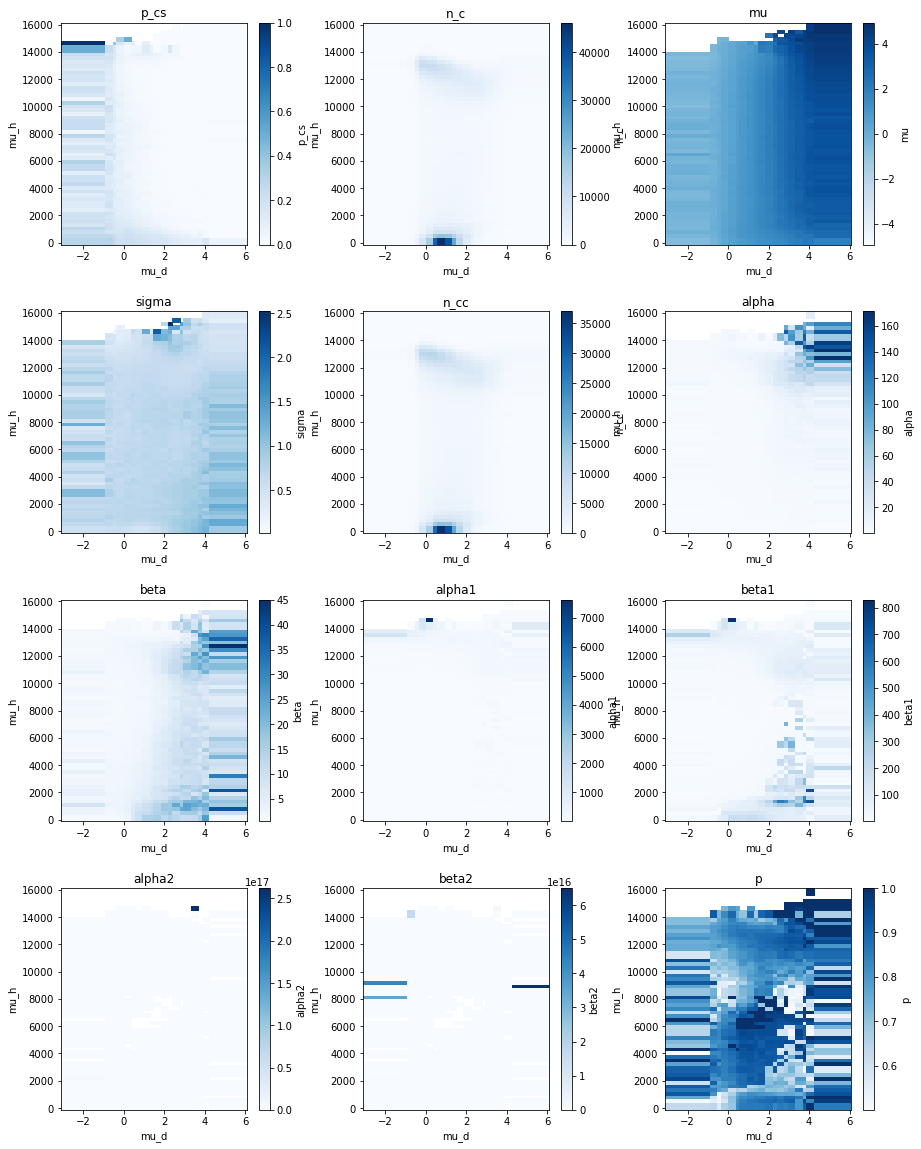

In [5]:
# mu_h = np.linspace(ds_c.mu_h.min(), ds_c.mu_h.max(), 60)
# mu_d = np.linspace(ds_c.mu_d.min(), ds_c.mu_d.max(), 50)
# ds = param_c(mu_h, mu_d)

mu_h = np.linspace(0, ml.h_max, 60)
mu_d = np.linspace(-3, 6, 50)
n_h, n_d = len(mu_h), len(mu_d)

ds = param_c(mu_h, mu_d, method = 'nearest')
# ds = ds_c

fig, ax = plt.subplots(4,3, figsize = (15, 20))
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)
axs = ax.flatten()
for i, var in zip(range(12),list(ds.keys())):
    if 'nu' in var:
        im = ds[var].plot(ax = axs[i], cmap = cm.Blues, norm = mpl.colors.LogNorm())
    else:
        im = ds[var].plot(ax = axs[i], cmap = cm.Blues)
    axs[i].set(title = var)



## Simulation

In [6]:
def step(x, ds_cs, ds_c):
    """Makes one step.
    Args:
        x (np.array): current state of the pixel (h, d)
    Returns:
        np.array: updated state of the pixel
    """

    x_is_cs = np.isnan(x).any()
    if x_is_cs:
        p_cs = ds_cs.theta1.data
    else:
        p_cs = theta_c_to_cs(*x, ds_c = ds_c, method = 'nearest')
    
#     print('x and p_cs', x, p_cs)
    
    # to cloud or clear sky
    x_next_is_cs = bernoulli.rvs(p_cs)
    
    if x_next_is_cs:
        h2, d2 = np.nan, np.nan
    else:               
        if x_is_cs: ## x current is cs
            cod_param = ds_cs.theta3[7:9].data
            cth_param = ds_cs.theta3[2:7].data

        else: ## x is cloud:
            cth_param = theta_c_to_c_cth(*x, ds_c = ds_c, method = 'nearest')
            cod_param = theta_c_to_c_cod(*x, ds_c = ds_c, method = 'nearest')
#         print(cod_param , cth_param)
        mu, sigma = cod_param
        alpha1, beta1, alpha2, beta2, p = cth_param
        d2 = np.random.randn(1) * sigma + mu   

        h_ = np.linspace(0, 1, 50)
        x = np.random.rand(1)
        y1 = beta.rvs(alpha1, beta1)
        if p == 1:
            h2 = y1
        else:
            y2 = beta.rvs(alpha2, beta2)
            u = (x < p)
        #     print('u, y1, y2', u, y1 ,y2)
            h2 = ml.UnitInttoCTH(u * y1 + ~u * y2)
    
    
    return h2, d2

def sim_model1(steps, ds_cs, ds_c,
                       init_cond='random', impulse_pos='center'):
    """Generate the state of an elementary cellular automaton after a pre-determined
    number of steps starting from some random state.
    Args:
        rule_number (int): the number of the update rule to use
        size (int): number of cells in the row
        steps (int): number of steps to evolve the automaton
        init_cond (str): either `random` or `impulse`. If `random` every cell
        in the row is activated with prob. 0.5. If `impulse` only one cell
        is activated.
        impulse_pos (str): if `init_cond` is `impulse`, activate the
        left-most, central or right-most cell.
    Returns:
        np.array: final state of the automaton
    """

    x = np.zeros((steps, 2))
    x[0,:] = np.array([1e3, 1])
    for i in range(steps - 1):
        print(i, end = '\r')
        x[i+1,:] = step(x[i,:], ds_cs, ds_c)
    print('finished')
    return x

cs_param = 3
n = 1000
x = sim_model1(n, ds_cs, ds)

finished


In [7]:
df = pd.DataFrame(x, columns = ['h_t', 'd_t'])
df['cloud'] = df.apply(lambda x : 'cloud' if ~np.isnan(x.h_t) else 'clear sky', axis = 1)
dqf = df.cloud.apply(lambda x : 6 if x == 'clear sky' else 0)
df['ISCCP'] = util.classifyISCCP(df.d_t, df.h_t, dqf , bound = [np.log(3.6), np.log(23), 2e3, 8e3]).astype(int)

df = df.append({'h_t' : np.nan, 'd_t' : np.nan}, ignore_index = True)
df['h_t_next'] = np.roll(df.h_t, -1)
df['d_t_next'] = np.roll(df.d_t, -1)
df['cloud_next'] = np.roll(df.cloud, -1)
df['ISCCP_next'] =  np.roll(df.ISCCP, -1)
df.to_csv(f'../data/simulation/model1/sim_n={len(df) - 1}.csv')
df

,h_t,d_t,cloud,ISCCP,h_t_next,d_t_next,cloud_next,ISCCP_next
0,1000.000000,1.000000,cloud,2.0,6734.526372,2.096210,cloud,6.0
1,6734.526372,2.096210,cloud,6.0,4721.339204,1.867317,cloud,6.0
2,4721.339204,1.867317,cloud,6.0,4292.311259,3.482808,cloud,9.0
3,4292.311259,3.482808,cloud,9.0,4810.833480,3.352327,cloud,9.0
4,4810.833480,3.352327,cloud,9.0,4837.874542,2.924767,cloud,6.0
...,...,...,...,...,...,...,...,...
996,104.988581,1.046947,cloud,2.0,168.155907,1.060907,cloud,2.0
997,168.155907,1.060907,cloud,2.0,343.308804,0.281907,cloud,2.0
998,343.308804,0.281907,cloud,2.0,NaN,NaN,clear sky,1.0
999,NaN,NaN,clear sky,1.0,NaN,NaN,NaN,NaN


# Simulation exploration

0.009649586398489172

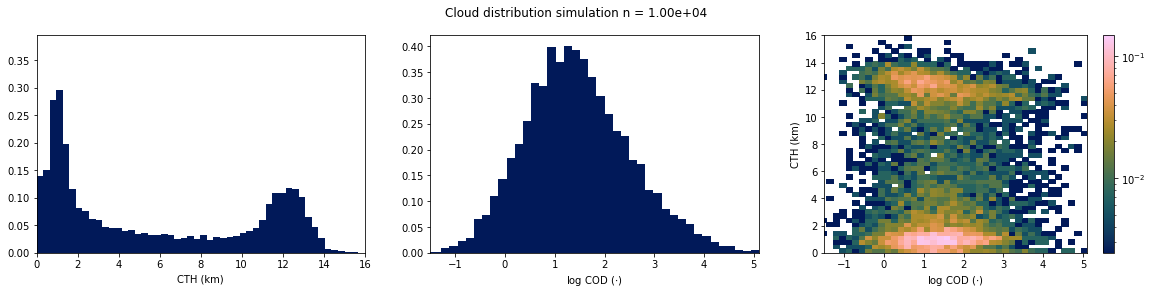

In [11]:
n = 10000
df = pd.read_csv(f'../data/simulation/model1/sim_n={n}.csv')
df_cc = df.dropna()
mp.plot_distribution_next_cloud(df_cc, ML = False, mixture = True, density = True, title = f'Cloud distribution simulation n = {len(df):.2e}')
df.h_t.min()

## Transition probabilities

In [25]:
T_total = pd.crosstab(df.ISCCP, df.ISCCP_next, rownames=['from'], colnames=[ 'to'], normalize = 'index', margins = True)
T = T_total#.iloc[:-1]
# T.columns, T.index = T.columns.astype(int), T.index.astype(int)
T.index[0]
T = T.rename(
            columns = util.ISCCP_classes, 
             index = util.ISCCP_classes
            )
T

import seaborn as sns
cmap = sns.light_palette("green", as_cmap=True)

T.style.background_gradient(cmap=plt.cm.Blues)


to,clear sky,cumulus,altocumulus,cirrus,stratocumulus,altostratus,cirrostratus,stratus,nimbostratus,deep convection
from,,,,,,,,,,
clear sky,0.717340,0.175178,0.016033,0.022565,0.054038,0.005938,0.008314,0.000594,0.000000,0.000000
cumulus,0.149851,0.408955,0.108657,0.031642,0.237015,0.044179,0.016119,0.002985,0.000597,0.000000
altocumulus,0.055825,0.212379,0.317961,0.138350,0.091019,0.143204,0.037621,0.001214,0.002427,0.000000
cirrus,0.036755,0.024965,0.088766,0.660888,0.003467,0.018031,0.167129,0.000000,0.000000,0.000000
stratocumulus,0.063125,0.261875,0.038750,0.006250,0.490000,0.083750,0.010625,0.039375,0.006250,0.000000
altostratus,0.012000,0.052000,0.128000,0.021000,0.147000,0.477000,0.077000,0.014000,0.064000,0.008000
cirrostratus,0.006531,0.001633,0.025306,0.206531,0.008163,0.067755,0.603265,0.001633,0.004082,0.075102
stratus,0.036232,0.065217,0.014493,0.000000,0.579710,0.079710,0.000000,0.181159,0.043478,0.000000
nimbostratus,0.000000,0.006211,0.018634,0.000000,0.037267,0.385093,0.080745,0.043478,0.391304,0.037267


In [35]:
loc_model1 = '../mod/model1/'
T_total_data = pd.read_csv(loc_model1 + 'expl_transition_ctypes.csv', index_col = 0)
T_data = T_total_data#.iloc[:-1]

print(T_data.index)
# T.columns, T.index = T.columns.astype(int), T.index.astype(int)
classes = {str(k) + '.0':v for k, v in util.ISCCP_classes.items()}
T_data = T_data.rename(
            columns = classes, 
             index = classes
            ).drop(['invalid pixel'], axis = 1).drop(['invalid pixel'])
T_data

Index(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       '10.0', 'All'],
      dtype='object', name='from')


,clear sky,cumulus,altocumulus,cirrus,stratocumulus,altostratus,cirrostratus,stratus,nimbostratus,deep convection
from,,,,,,,,,,
clear sky,0.748846,0.119407,0.016537,0.059605,0.036653,0.002945,0.013687,0.000825,0.000100,0.000205
cumulus,0.176882,0.522721,0.060487,0.058385,0.148999,0.014564,0.010262,0.004083,0.000601,0.000361
altocumulus,0.060011,0.133837,0.386327,0.193412,0.031283,0.146011,0.038981,0.001090,0.005341,0.001233
cirrus,0.072735,0.042969,0.061524,0.678427,0.008358,0.013143,0.116818,0.000271,0.000437,0.002092
stratocumulus,0.107668,0.304109,0.026847,0.022895,0.438904,0.045888,0.022435,0.024449,0.004011,0.001188
altostratus,0.009189,0.030944,0.130582,0.037556,0.050856,0.572714,0.093322,0.003696,0.060473,0.009623
cirrostratus,0.022322,0.010831,0.016543,0.156770,0.012157,0.043974,0.661905,0.000733,0.004877,0.067888
stratus,0.028794,0.116405,0.013526,0.010042,0.468696,0.062301,0.023261,0.219592,0.047443,0.007173
nimbostratus,0.001148,0.006097,0.019655,0.005846,0.025143,0.342635,0.058463,0.015961,0.451670,0.070012


In [36]:
T_diff = (T_data - T)
T_diff.style.background_gradient(cmap=plt.cm.Blues)


,clear sky,cumulus,altocumulus,cirrus,stratocumulus,altostratus,cirrostratus,stratus,nimbostratus,deep convection
from,,,,,,,,,,
clear sky,0.031506,-0.055771,0.000504,0.037039,-0.017385,-0.002994,0.005373,0.000231,0.000100,0.000205
cumulus,0.027031,0.113765,-0.048170,0.026743,-0.088016,-0.029615,-0.005858,0.001098,0.000004,0.000361
altocumulus,0.004186,-0.078541,0.068366,0.055063,-0.059737,0.002807,0.001359,-0.000124,0.002914,0.001233
cirrus,0.035980,0.018004,-0.027241,0.017539,0.004891,-0.004887,-0.050311,0.000271,0.000437,0.002092
stratocumulus,0.044543,0.042234,-0.011903,0.016645,-0.051096,-0.037862,0.011810,-0.014926,-0.002239,0.001188
altostratus,-0.002811,-0.021056,0.002582,0.016556,-0.096144,0.095714,0.016322,-0.010304,-0.003527,0.001623
cirrostratus,0.015791,0.009198,-0.008763,-0.049761,0.003994,-0.023781,0.058640,-0.000900,0.000795,-0.007214
stratus,-0.007438,0.051188,-0.000967,0.010042,-0.111015,-0.017409,0.023261,0.038433,0.003965,0.007173
nimbostratus,0.001148,-0.000114,0.001021,0.005846,-0.012125,-0.042458,-0.022283,-0.027518,0.060365,0.032745


{'clear sky': Text(-1.0, 0.8, 'clear sky'),
 'cumulus': Text(0.0, -0.2, 'cumulus'),
 'altocumulus': Text(0.0, 0.8, 'altocumulus'),
 'cirrus': Text(0.0, 1.8, 'cirrus'),
 'stratocumulus': Text(1.0, -0.2, 'stratocumulus'),
 'altostratus': Text(1.0, 0.8, 'altostratus'),
 'cirrostratus': Text(1.0, 1.8, 'cirrostratus'),
 'stratus': Text(2.0, -0.2, 'stratus'),
 'nimbostratus': Text(2.0, 0.8, 'nimbostratus'),
 'deep convection': Text(2.0, 1.8, 'deep convection')}

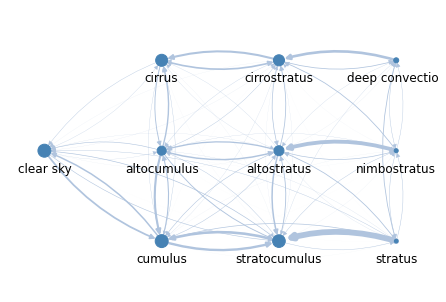

In [104]:
from itertools import combinations_with_replacement
import random
import networkx as nx

random.seed(0)

node_names = list(util.ISCCP_classes.values())[1:]
G = nx.DiGraph()
G.add_nodes_from(node_names)

for (u, v) in combinations_with_replacement(node_names, 2):
    G.add_edge(u, v, weight = T.loc[u,v])
    G.add_edge(v, u, weight = T.loc[v,u])

# for (u, v, weight) in G.edges.data('weight'):
#     print(f"Edge {u} -> {v} weights {weight}.")
    

pos = {'clear sky': np.array([-1, 1]),
         'cumulus': np.array([ 0, 0]),
         'altocumulus': np.array([0,  1]),
         'cirrus': np.array([0,  2]),
         'stratocumulus': np.array([1, 0 ]),
         'altostratus': np.array([1, 1]),
         'cirrostratus': np.array([1, 2]),
         'stratus': np.array([ 2, 0]),
         'nimbostratus': np.array([2, 1]),
         'deep convection': np.array([2, 2])}
edge_widths = [w * 10 for (*edge, w) in G.edges.data('weight')]
node_size = T.loc['All'] * 1000
labels = {item:item for item in node_names}

nx.draw(G, pos, width=edge_widths, node_size = node_size,
        edge_color = 'lightsteelblue',
        node_color = 'steelblue',
        connectionstyle='arc3, rad=.15')

pos_labels = {k: v + [0, -.2] for k, v in pos.items()}
nx.draw_networkx_labels(G, pos_labels)

In [33]:
dh = 300
dd = .3
mu_h = np.arange(1e3, 15e3, dh) # m
mu_d = np.arange(-1, 4, dd)
n_h = len(mu_h)
n_d = len(mu_d)


bins, bin_center = me.state_bins(mu_h, mu_d, delta_h = dh/2, delta_d = dd/2)


## 1. clear sky to clear sky

In [10]:
me.p_cs_to_cs(df)

0.7173396674584323

## 2. cloud to clear sky

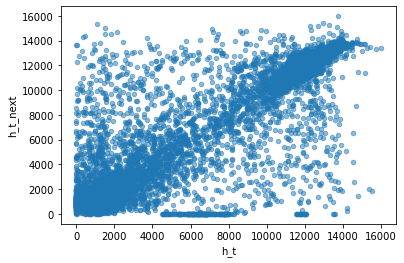

In [7]:
df_cc.plot.scatter('h_t', 'h_t_next', alpha = .5)

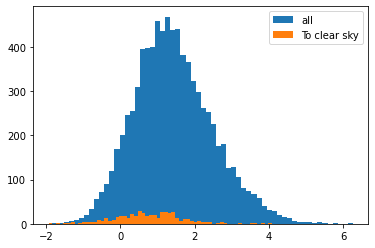

In [8]:
plt.hist(df.loc[:,'d_t'], bins = 60, label = 'all')
plt.hist(df.loc[df.cloud_next == 'clear sky'].d_t, bins = 60, label = 'To clear sky')
plt.legend()


In [9]:
pd.crosstab(df.cloud, df.cloud_next, rownames=['from'], colnames=[ 'to'], margins = True, normalize = 'index')

to,clear sky,cloud
from,,
clear sky,0.717340,0.282660
cloud,0.057246,0.942754
All,0.168417,0.831583


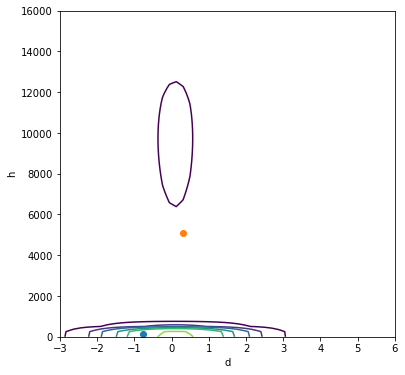

In [317]:
i = 19

fig = plt.figure(figsize =(6,6))
plt.xlim([-3, 6])
plt.ylim(np.array(mp.hlim) * 1e3)


def plot_state_with_distr(i, df = df):
    s = df.iloc[i]
    plt.title(f't = {i}')

    ## pdf's
    params = modelThtoDistrTh((s.h_t, s.d_t), cod_param, cth_param)

    ds = xr.Dataset(
        data_vars=dict(
        ),
        coords=dict(
            h=mu_h,
            d=mu_d,
        ),
        )

    alpha1 = params.mu1 * params.nu1
    beta1 = params.nu1 - alpha1
    alpha2 = params.mu2 * params.nu2
    beta2 = params.nu2 - alpha2

    ds['pdf_cth'] = (['h'], ml.pdf_bmix(ml.CTHtoUnitInt(ds.h), alpha1, beta1, alpha2, beta2, params.p))
    ds['pdf_cod'] = (['d'], norm(params.mu,params.sigma).pdf(ds.d))
    ds = ds.assign(pdf = ds.pdf_cth * ds.pdf_cod)
    if i == 0: 
        cb = True
    else: 
        cb = False
    ds.pdf.plot.contour(add_colorbar = cb, levels = [.1, .5, 1, 2, 3, 6, 10])

    plt.scatter(s.d_t, s.h_t, label = '$s_t$')
    plt.scatter(s.d_t_next, s.h_t_next, label = '$s_{t+1}$')
    
    if cb:
        plt.legend()

plot_state_with_distr(i)
# x

In [319]:
def jointprob(s):
    plt.title(f't = {i}')

    ## pdf's
    params = modelThtoDistrTh((s.h_t, s.d_t), cod_param, cth_param)

    
    
    ds = xr.Dataset(
        data_vars=dict(
        ),
        coords=dict(
            h=mu_h,
            d=mu_d,
        ),
        )

    alpha1 = params.mu1 * params.nu1
    beta1 = params.nu1 - alpha1
    alpha2 = params.mu2 * params.nu2
    beta2 = params.nu2 - alpha2

    ds['pdf_cth'] = (['h'], ml.pdf_bmix(ml.CTHtoUnitInt(ds.h), alpha1, beta1, alpha2, beta2, params.p))
    ds['pdf_cod'] = (['d'], norm(params.mu,params.sigma).pdf(ds.d))
    ds = ds.assign(pdf = ds.pdf_cth * ds.pdf_cod)
    return ds


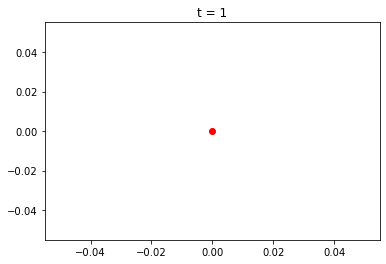

In [274]:
i = 1
s = df.iloc[i]
plt.title(f't = {i}')

cloudt = np.isnan(s.h_t)
# cloud
plt.scatter(0,0, c =  'r')

C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
../lib\ml_estimation.py:66: RuntimeWarning: invalid value encountered in less_equal
  if p <= 0:
../lib\ml_estimation.py:68: RuntimeWarning: invalid value encountered in greater_equal
  elif p >= 1:
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1761: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\nerin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1762: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)
C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\nerin\anaconda3\lib\site-packages\matplotlib\contour.py:1484: UserWarnin

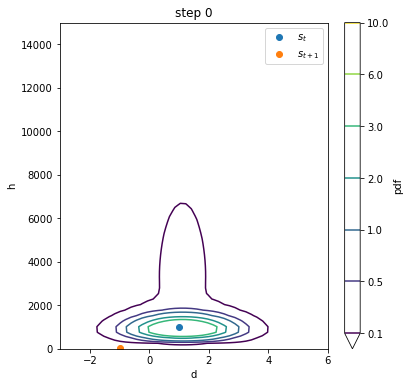

In [320]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
# fig = plt.figure()
# line, = ax.plot([], [], lw=2)

fig = plt.figure(figsize =(6,6))
ax = plt.axes()
plt.xlim([-3, 6])
plt.ylim(np.array(mp.hlim) * 1e3)
ds = jointprob(df.iloc[0])
ds.pdf.plot.contour( add_colorbar = True, levels = [.1, .5, 1, 2, 3, 6, 10], ax = ax)


# animation function.  This is called sequentially
def animate(i):
    ax.clear()
    s = df.iloc[i]
    plt.title(f't = {i}')

    cloudt = np.isnan(s.h_t)
    cloudt1 = np.isnan(s.h_t_next)
    ## pdf's
    params = modelThtoDistrTh((s.h_t, s.d_t), cod_param, cth_param)

    ds = xr.Dataset(
        data_vars=dict(
        ),
        coords=dict(
            h=mu_h,
            d=mu_d,
        ),
        )

    alpha1 = params.mu1 * params.nu1
    beta1 = params.nu1 - alpha1
    alpha2 = params.mu2 * params.nu2
    beta2 = params.nu2 - alpha2

    ds['pdf_cth'] = (['h'], ml.pdf_bmix(ml.CTHtoUnitInt(ds.h), alpha1, beta1, alpha2, beta2, params.p))
    ds['pdf_cod'] = (['d'], norm(params.mu,params.sigma).pdf(ds.d))
    ds = ds.assign(pdf = ds.pdf_cth * ds.pdf_cod)

    ds.pdf.plot.contour(add_colorbar = False, levels = [.1, .5, 1, 2, 3, 6, 10], ax = ax)
    
    
    if cloudt:
        ax.scatter([-3], [0], c = 'r', label = '$s_t$')
    else: 
        ax.scatter(s.d_t, s.h_t, label = '$s_t$')
    
    if cloudt1:
        ax.scatter([-3], [0], c = 'r', label = '$s_{t+1}$')
    else:     
        ax.scatter(s.d_t_next, s.h_t_next, label = '$s_{t+1}$')
        
    ax.set_title('step ' + str(i))
    ax.legend()
    return 

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=100, interval=2000)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=1, extra_args=['-vcodec', 'libx264'])



In [277]:
anim
